In [1]:
# For files e data manipulations
from neuralNetwork import *

Working Well


## Neural Network

In [2]:
pnn = PreNeuralNetwork()

In [3]:
dir_train = 'C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/archive/train'
dir_test  = 'C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/archive/test'
dir_valid = 'C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/archive/validation'
# dir_train = 'C:/Users/Lucas/PIBIC/new_dir_train'
# dir_test  = 'C:/Users/Lucas/PIBIC/new_dir_test'
# dir_valid = 'C:/Users/Lucas/PIBIC/new_dir_valid'

batch_size = 64
width = 224
length = 224
channel = 3
image_size = (width, length)
random.seed(123) 

Como está dando o CLOCK_WATCHDOG_TIMEOUT reduzirei a quantidade de imagens

In [4]:
train_datagen= ImageDataGenerator(rescale=1.0/255)
val_datagen  = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator=train_datagen.flow_from_directory(dir_train,
                                        target_size=image_size,
                                        color_mode='rgb',  # Ensure RGB color mode
                                        class_mode='categorical',  # Adjust class_mode as needed
                                        batch_size=batch_size,
                                        subset='training'  # Specify 'training' for the training set
                                    )

val_generator=val_datagen.flow_from_directory(dir_valid,
                                        target_size=image_size,
                                        color_mode='rgb',
                                        class_mode='categorical',
                                        batch_size=batch_size
                                    )

test_generator=test_datagen.flow_from_directory(dir_test,
                                        target_size=image_size,
                                        color_mode='rgb',
                                        class_mode='categorical',
                                        batch_size=batch_size
                                    )

Found 77877 images belonging to 9 classes.
Found 4328 images belonging to 9 classes.
Found 4326 images belonging to 9 classes.


In [5]:
n_classes = train_generator.num_classes
print("Number of classes:", n_classes)

Number of classes: 9


In [6]:
# Assuming you have a GPU with index 0
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Specify GPU device
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)


if tf.test.is_gpu_available():
    print("GPU is available and accessible.")
else:
    print("GPU is not available.")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is not available.


In [7]:
5151ppp

SyntaxError: invalid decimal literal (106419868.py, line 1)

In [ ]:
num_classes = n_classes  # Adjust the number of classes as needed
image_shape = (width,length,channel)  # Adjust image dimensions as needed
model = EfficientNetModelB7(num_classes, image_shape)

# Train the model
history_b7 = model.train(train_generator, val_generator, epochs=20, batch_size=batch_size, early_stop_patience=5)


# num_classes = n_classes  # Adjust the number of classes as needed
# image_shape = (width,length,channel)  # Adjust image dimensions as needed
# model = EfficientNetModelB4(num_classes, image_shape)

# # Train the model
# history_b4 = model.train(train_generator, val_generator, epochs=20, batch_size=batch_size, early_stop_patience=5)

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)

In [ ]:
df_results = model.create_metrics_dataframe(history_b7)
df_results

In [ ]:
model.plot_history(history_b7)

In [9]:
model = ResNet101Model(num_classes, image_shape)

# Train the model
history_101 = model.train(train_generator, val_generator, epochs=20, batch_size=batch_size, early_stop_patience=5)

Epoch 1/20
1217/1217 [==============================] - 3470s 3s/step - loss: 1.1690 - accuracy: 0.6873 - val_loss: 5.5805 - val_accuracy: 0.0455
Epoch 2/20
1217/1217 [==============================] - 3512s 3s/step - loss: 1.1258 - accuracy: 0.6950 - val_loss: 2.9226 - val_accuracy: 0.0310
Epoch 3/20
1217/1217 [==============================] - 3532s 3s/step - loss: 1.1173 - accuracy: 0.6947 - val_loss: 1.4367 - val_accuracy: 0.7003
Epoch 4/20
1217/1217 [==============================] - 3531s 3s/step - loss: 1.1124 - accuracy: 0.6955 - val_loss: 3.6839 - val_accuracy: 0.0187
Epoch 5/20
1217/1217 [==============================] - 3526s 3s/step - loss: 1.1072 - accuracy: 0.6951 - val_loss: 4.9290 - val_accuracy: 0.0448
Epoch 6/20
1217/1217 [==============================] - 3519s 3s/step - loss: 1.1051 - accuracy: 0.6954 - val_loss: 1.8144 - val_accuracy: 0.7038
Epoch 7/20
1217/1217 [==============================] - 3553s 3s/step - loss: 1.1011 - accuracy: 0.6953 - val_loss: 5.1827 -

68/68 [==============================] - 187s 3s/step - loss: 1.4717 - accuracy: 0.6930


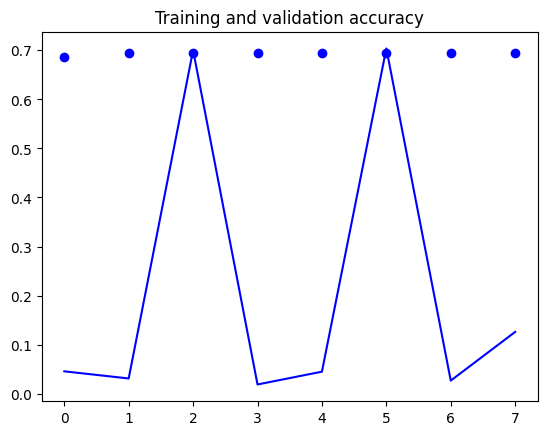

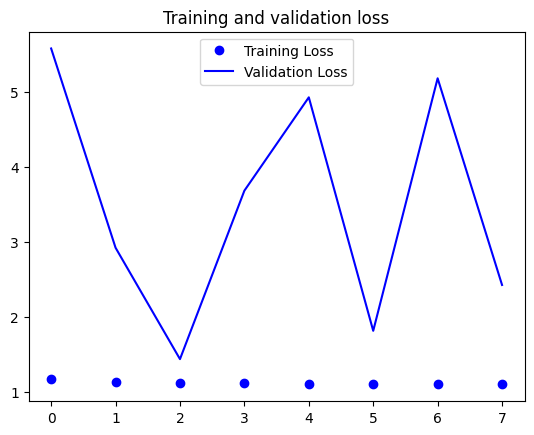

In [10]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
df_results = model.create_metrics_dataframe(history_101)
model.plot_history(history_101)

In [11]:
df_results

,epoch,train_loss,val_loss,train_accuracy,val_accuracy
0,1,1.168971,5.580523,0.687250,0.045518
1,2,1.125828,2.922603,0.694968,0.030961
2,3,1.117281,1.436661,0.694685,0.700323
3,4,1.112399,3.683862,0.695494,0.018715
4,5,1.107211,4.928956,0.695058,0.044824
5,6,1.105107,1.814439,0.695430,0.703789
6,7,1.101101,5.182717,0.695314,0.026571
7,8,1.098407,2.425920,0.695404,0.125924
